In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
import torch
import time
import numpy as np

from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms

from local_logger import Logger
import blundell

from matplotlib import pyplot as plt

In [3]:
# use GPU for computation if possible
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# Load a dataset
def get_mnist(batch_size):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./data', train=True, download=True,
        transform=transform), batch_size=batch_size, shuffle=True, num_workers=4)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./data', train=False, download=True,
        transform=transform), batch_size=batch_size, shuffle=True, num_workers=4)

    return train_loader, test_loader

In [20]:
# Structure for 1-d curve fitting
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = blundell.Linear(28 * 28, 300)
        self.fc2 = blundell.Linear(300,  100)
        self.fc3 = blundell.Linear(100, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1)
        return x

In [21]:
model = Net().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50,60,70,80], gamma=0.2)

fmt = {'tr_los': '3.1e', 'te_loss': '3.1e', 'sp_0': '.3f', 'sp_1': '.3f', 'lr': '3.1e', 'kl': '.2f'}
logger = Logger('sparse_vd', fmt=fmt)

train_loader, test_loader = get_mnist(batch_size=100)
loss_function = blundell.Loss(model, train_size=len(train_loader.dataset), problem='classification').to(DEVICE)

In [22]:
MNIST_INPUT_SHAPE = 28 * 28
epochs = 40

for epoch in range(1, epochs + 1):
    start = time.time()
    model.train()
    train_loss, train_acc = 0, 0
    logger.add_scalar(epoch, 'lr', scheduler.get_last_lr()[0])
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(DEVICE)
        target = target.to(DEVICE)
        data = data.view(-1, MNIST_INPUT_SHAPE)
        optimizer.zero_grad()

        output = model(data)
        loss = loss_function(data, target)
        loss.backward()
        optimizer.step()

        train_loss += loss
        pred = output.data.max(1)[1]
        train_acc += np.sum(pred.cpu().numpy() == target.cpu().data.numpy())

    scheduler.step()

    logger.add_scalar(epoch, 'tr_los', train_loss / len(train_loader.dataset))
    logger.add_scalar(epoch, 'tr_acc', train_acc / len(train_loader.dataset) * 100)


    model.eval()
    test_loss, test_acc = 0, 0
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(DEVICE)
        target = target.to(DEVICE)
        data = data.view(-1, MNIST_INPUT_SHAPE)
        output = model(data)
        test_loss += float(loss_function(data, target)) #, kl_weight))
        pred = output.data.max(1)[1]
        test_acc += np.sum(pred.cpu().numpy() == target.cpu().data.numpy())

    logger.add_scalar(epoch, 'te_loss', test_loss / len(test_loader.dataset))
    logger.add_scalar(epoch, 'te_acc', test_acc / len(test_loader.dataset) * 100)

    for i, c in enumerate(model.children()):
        if hasattr(c, 'kl_reg'):
            logger.add_scalar(epoch, 'kl_reg_%s' % i, -c.kl_reg())

    end = time.time()
    logger.add_scalar(epoch, 'time', end - start)

    logger.iter_info()

  epoch       lr    tr_los    tr_acc    te_loss    te_acc    kl_reg_0    kl_reg_1    kl_reg_2    time
-------  -------  --------  --------  ---------  --------  ----------  ----------  ----------  ------
      1  1.0e-03   6.0e+02      84.4    5.8e+02      95.0   -499532.7    -64221.4     -2155.9    24.1
      2  1.0e-03   5.8e+02      93.9    5.7e+02      96.3   -496542.3    -63899.4     -2171.6    17.0
      3  1.0e-03   5.7e+02      95.5    5.6e+02      97.0   -493159.9    -63646.8     -2133.3    16.4
      4  1.0e-03   5.6e+02      96.5    5.6e+02      97.4   -490195.6    -63316.5     -2157.2    16.7
      5  1.0e-03   5.6e+02      96.9    5.6e+02      97.5   -487262.7    -63158.6     -2157.6    16.8
      6  1.0e-03   5.6e+02      97.3    5.5e+02      97.7   -484900.8    -62875.0     -2180.7    16.6
      7  1.0e-03   5.5e+02      97.7    5.5e+02      97.9   -482537.1    -62647.7     -2176.2    16.7
      8  1.0e-03   5.5e+02      97.8    5.5e+02      97.8   -479968.1    -62384.0 

### Plot test results:
##### *Prediction* vs *True*, *Confidence* (softmax proba)

In [110]:
# plot a grid of `images` with `nrows` rows and `ncols` columns
def plot_images(images, labels, targets, proba, nrows=4, ncols=4):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(1.5 * ncols, 1.5 * nrows))
    i = 0
    for image, ax in zip(images, axes.flat):
        # configure subplot
        ax.set_xticks(())
        ax.set_yticks(())
        ax.grid(False)

        # plot image
        # if type(image) == torch.Tensor:
        image = image.view(28, 28).cpu().numpy()
        ax.imshow(image, vmin=0.0, vmax=1.0, cmap='gray_r')

        # put the predicted label and the true target
        ax.set_title(f"{labels[i]:.0f} vs {targets[i]:.0f}, {proba[i]:.2f}")
        i += 1

    plt.tight_layout()
    return fig

/var/folders/jk/_35jq9kx1zlchrr2qjmy3tnr0000gn/T/ipykernel_55834/3177259020.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


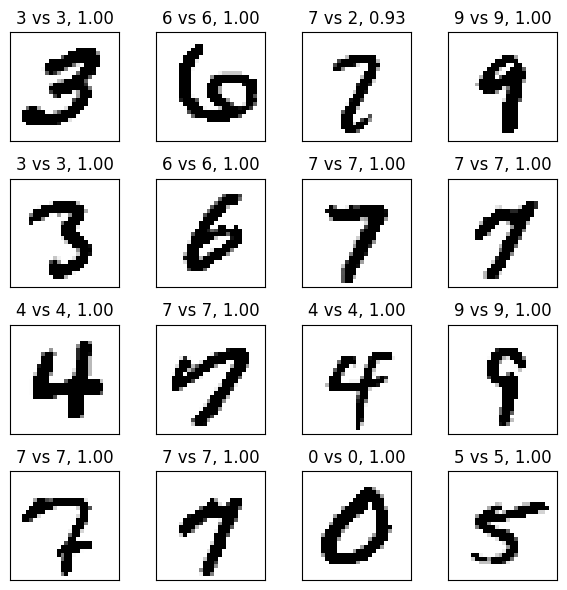

In [111]:
_, test_loader = get_mnist(batch_size=16)
data, target = next(iter(test_loader))

data = data.to(DEVICE)
target = target.to(DEVICE)
data = data.view(-1, MNIST_INPUT_SHAPE)
output = model(data)
proba, pred = torch.exp(output).max(1)
labels = pred.cpu().numpy()

fig = plot_images(data, labels, target, proba)
fig.show()

### Rotate digit and see how confidence changes

In [112]:
# Load a noisy test dataset
def get_rotated_mnist_digits(angles):
    transform = transforms.Compose([
        # transforms.RandomRotation(degrees=(angle, angle)), 
        transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    loader = torch.utils.data.DataLoader(
        datasets.MNIST('./data', train=False, download=False,
        transform=transform), batch_size=1, shuffle=True)
    digit, label = next(iter(loader))

    digits = torch.Tensor(len(angles), *digit.size())
    labels = torch.Tensor(len(angles), *label.size())
    for i, angle in enumerate(angles):
        rotation = transforms.RandomRotation(degrees=(angle, angle))
        digits[i] = rotation(digit)
        labels[i] = label
    

    return digits, labels

/var/folders/jk/_35jq9kx1zlchrr2qjmy3tnr0000gn/T/ipykernel_55834/2368626534.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


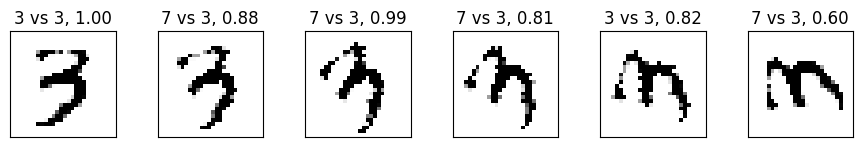

In [114]:
digits, labels = get_rotated_mnist_digits(angles=np.linspace(0, 90, 6))

data = digits.to(DEVICE)
data = data.view(-1, MNIST_INPUT_SHAPE)
target = labels.to(DEVICE)

# model.train()
output = model(data)
proba, pred = torch.exp(output).max(1)
pred_label = pred.cpu()

pred_label = pred_label.numpy().squeeze()
target = target.numpy().squeeze()
proba = proba.detach().numpy().squeeze()

fig = plot_images(data, pred_label, target, proba, nrows=1, ncols=6)
fig.show()